# Feature Engineering

## A. Import Library

In [44]:
import numpy as np     # for calculation
import pandas as pd     # for manipulating DataFrame
import seaborn as sns     # for plotting data
import matplotlib.pyplot as plt     # for plotting data
import yaml     # for interacting with config.yaml  
import src.util as util     # import common function
from sklearn.preprocessing import OneHotEncoder     # for manipulating categorical data
from sklearn.preprocessing import StandardScaler     # for normalize data
from imblearn.under_sampling import RandomUnderSampler     # for creating random under sample data
from imblearn.over_sampling import RandomOverSampler, SMOTE     # for creating random over sample and SMOTE data

## B. Import Data

In [45]:
config = util.load_config()

loading configuration file .....
configuration file loaded


In [46]:
config

{'raw_dataset_dir': 'data/raw/',
 'raw_data_path': 'data/processed/raw_data.pkl',
 'data_train_path': ['data/processed/X_train_clean.pkl',
  'data/processed/y_train_clean.pkl'],
 'data_test_path': ['data/processed/X_test_clean.pkl',
  'data/processed/y_test_clean.pkl'],
 'data_modeling_path': ['data/processed/train_data_modeling.pkl',
  'data/processed/test_data_modeling.pkl'],
 'ohe_train_path': 'models/ohe_train.pkl',
 'standard_scaler_path': 'models/standard_scaler_train.pkl',
 'modeling_summary': 'models/modeling_summary.pkl',
 'production_model': 'models/production_model.pkl',
 'api_columns': ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M']}

In [47]:
X_train_clean = util.load_pickle(file_path=config['data_train_path'][0])
y_train_clean = util.load_pickle(file_path=config['data_train_path'][1])
X_test_clean = util.load_pickle(file_path=config['data_test_path'][0])
y_test_clean = util.load_pickle(file_path=config['data_test_path'][1])

## C. Feature Selection Data Train

### C.1. RELPOS Feature

In [48]:
X_train_clean.groupby(["Well Name","Formation"]).aggregate({'Depth':['min','max'],'RELPOS':['min','max']})

Depth         RELPOS       
                          min     max    min    max
Well Name   Formation                              
ALEXANDER D A1 LM      2907.5  2939.0  0.015  0.985
            A1 SH      2887.5  2906.5  0.026  1.000
            B1 LM      2956.0  2966.0  0.048  1.000
            B1 SH      2939.5  2955.5  0.031  1.000
            B2 LM      2978.0  2987.5  0.050  1.000
...                       ...     ...    ...    ...
SHRIMPLIN   B4 SH      2911.0  2925.0  0.034  1.000
            B5 LM      2938.0  2948.0  0.050  1.000
            B5 SH      2930.0  2937.5  0.118  1.000
            C LM       2977.5  3028.0  0.010  0.990
            C SH       2948.5  2976.5  0.018  1.000

[127 rows x 4 columns]

In [49]:
X_train_clean.loc[(X_train_clean["Well Name"]=='ALEXANDER D') & (X_train_clean["Formation"]=='A1 SH')][['Depth','RELPOS']].corr()

,Depth,RELPOS
Depth,1.0,-1.0
RELPOS,-1.0,1.0


from this analysis we know that variable depth and RELPOS are strongly correlated, we can say that RELPOS is MinMaxScaller of depth for every formation group, hence for modeling purpose we could drop **Depth, RELPOS and, Formation**

### C.2. Formation Features

In [50]:
X_train_clean["Formation"].unique()

array(['C LM', 'A1 LM', 'B4 LM', 'B2 LM', 'B1 SH', 'B2 SH', 'B1 LM',
       'A1 SH', 'C SH', 'B5 SH', 'B3 SH', 'B4 SH', 'B5 LM', 'B3 LM'],
      dtype=object)

formation data contains formation name in every well data, this is just a naming convention for labeling the reservoar under the surface. This data is meaningless for lithofacies classification so I would drop it from the feature modeling

### C.3. Depth Features

In [51]:
X_train_clean["Depth"].value_counts().sum()

3319

because depth is highly unique, and I know that there are no correlation between depth and lithofacies category, hence for modeling purpose I would drop this features

### C.4. Well Name Features

In [52]:
X_train_clean["Well Name"].unique()

array(['NEWBY', 'CHURCHMAN BIBLE', 'Recruit F9', 'SHRIMPLIN', 'KIMZEY A',
       'CROSS H CATTLE', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'NOLAN'],
      dtype=object)

well data feature is just an identifier for the source of the data, hence this feature isn't important for this lithofacies classification. From this feature selection activity we know that our input for classification problem is come from wireline measurement feature (GR, ILD_log10, PE, DeltaPHI, PHIND) and the output for classification is Facies Label, the rest of the feature will be dropped from modeling

In [53]:
def split_numerical_categorical(data:pd.DataFrame):
    data = data[["GR","ILD_log10","DeltaPHI","PHIND","PE","NM_M"]]
    X_train_categorical = data["NM_M"]
    X_train_numerical = data.drop(columns="NM_M", axis=1)
    
    return X_train_numerical, X_train_categorical

In [54]:
X_train_numerical, X_train_categorical = split_numerical_categorical(data=X_train_clean)

In [55]:
X_train_numerical.head(5)

,GR,ILD_log10,DeltaPHI,PHIND,PE
2720,48.640,0.940,4.100,6.850,4.100
3372,50.469,0.805,6.166,10.680,3.141
3327,99.188,0.573,3.866,13.175,3.232
2756,39.750,0.733,0.900,10.040,5.500
3299,40.250,0.873,-1.021,5.318,4.520


In [56]:
X_train_categorical.head(5)

2720    2
3372    2
3327    2
2756    2
3299    2
Name: NM_M, dtype: int32

## D. Handling Categorical Data

In [57]:
def categorical_handling(data:pd.Series) -> pd.DataFrame:
    non_marine_marine_label = {1:"non_marine",2:"marine"}
    data_marine = data.map(non_marine_marine_label)
    ohe_train = OneHotEncoder(sparse=False)
    ohe_train.fit(np.array(["non_marine","marine"]).reshape(-1,1))
    ohe_data = ohe_train.transform(np.array(data_marine.to_list()).reshape(-1,1))
    ohe_data = pd.DataFrame(data=ohe_data, columns=list(ohe_train.categories_[0]), index=data_marine.index)
    
    return ohe_data, ohe_train

In [58]:
X_train_categorical, ohe_train = categorical_handling(data=X_train_categorical)

In [59]:
ohe_train

OneHotEncoder(sparse=False)

In [60]:
util.dump_pickle(data=ohe_train, file_path=config["ohe_train_path"])

In [61]:
X_train_categorical.head(5)

,marine,non_marine
2720,1.0,0.0
3372,1.0,0.0
3327,1.0,0.0
2756,1.0,0.0
3299,1.0,0.0


## E. Normalize Feature Value

In [62]:
def normalize_data(numerical_data:pd.DataFrame, categorical_data:pd.DataFrame) -> pd.DataFrame:
    data = pd.concat([numerical_data, categorical_data], axis=1)
    standard_scaler_train = StandardScaler()
    standard_scaler_train.fit(data.values)
    normalized_data = standard_scaler_train.transform(data.values)
    normalized_data = pd.DataFrame(data=normalized_data, index=data.index, columns=data.columns)
    
    return normalized_data, standard_scaler_train

In [63]:
X_train, standard_scaler_train = normalize_data(numerical_data=X_train_numerical,
                                                categorical_data=X_train_categorical)

In [64]:
standard_scaler_train

StandardScaler()

In [65]:
util.dump_pickle(data=standard_scaler_train, file_path=config['standard_scaler_path'])

In [66]:
X_train.head(5)

,GR,ILD_log10,DeltaPHI,PHIND,PE,marine,non_marine
2720,-0.547132,1.102230,-0.059163,-0.881636,0.431062,0.964766,-0.964766
3372,-0.484870,0.567029,0.328611,-0.348468,-0.709061,0.964766,-0.964766
3327,1.173602,-0.352723,-0.103083,-0.001143,-0.600875,0.964766,-0.964766
2756,-0.849761,0.281589,-0.659780,-0.437561,2.095475,0.964766,-0.964766
3299,-0.832740,0.836612,-1.020339,-1.094904,0.930386,0.964766,-0.964766


In [67]:
X_train.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,marine,non_marine
count,3.319000e+03,3.319000e+03,3.319000e+03,3.319000e+03,3.319000e+03,3.319000e+03,3.319000e+03
mean,-4.103125e-17,4.282337e-16,-6.489402e-17,1.729392e-16,3.260088e-16,-1.631048e-16,1.703301e-16
std,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00
min,-1.857426e+00,-2.727227e+00,-4.926420e+00,-1.758650e+00,-4.205518e+00,-1.036521e+00,-9.647661e-01
25%,-6.804214e-01,-6.421283e-01,-5.283953e-01,-6.589027e-01,-6.876618e-01,-1.036521e+00,-9.647661e-01
50%,1.353307e-02,-7.521187e-02,-2.162395e-02,-1.674968e-01,-1.633716e-01,9.647661e-01,-9.647661e-01
75%,5.053146e-01,6.423536e-01,5.845309e-01,3.907292e-01,6.688350e-01,9.647661e-01,1.036521e+00
max,1.009120e+01,4.511657e+00,2.785702e+00,9.913981e+00,5.179395e+00,9.647661e-01,1.036521e+00


after scaling, we could see that for every wireline measurement feature, now they are having standard deviation equal to 1 and mean equal to 0

## F. Label Encoding Output Feature

In [68]:
def facies_encoder(data:pd.Series) -> pd.Series :
    facies_label_encoder = {'SS':0, 'CSiS':1, 'FSiS':2, 'SiSh':3, 'MS':4, 'WS':5, 'D':6, 'PS':7, 'BS':8}
    encoded_data = data.map(facies_label_encoder)
    
    return encoded_data

In [69]:
y_train_numerical = facies_encoder(data=y_train_clean)

In [70]:
y_train_numerical.head(5)

2720    5
3372    5
3327    5
2756    8
3299    7
Name: Facies, dtype: int64

as you can see, the facies data now already encoded by using label encoder in dictionary 'facies_label_encoder'

## G. Balancing Train Data

### G.1 Unbalance Train Data

In [71]:
inverse_facies_label_encoder = {0:'SS', 1:'CSiS', 2:'FSiS', 3:'SiSh', 4:'MS', 5:'WS', 6:'D', 7:'PS', 8:'BS'}
facies_colors_pallete = {'SS':'#F4D03F', 'CSiS':'#F5B041', 'FSiS':'#DC7633','SiSh':'#6E2C00',
       'MS':'#1B4F72', 'WS':'#2E86C1', 'D':'#AED6F1', 'PS':'#A569BD', 'BS':'#196F3D'}

In [72]:
y_train_clean.value_counts()

CSiS    752
FSiS    624
PS      549
WS      465
MS      237
SiSh    217
SS      214
BS      148
D       113
Name: Facies, dtype: int64

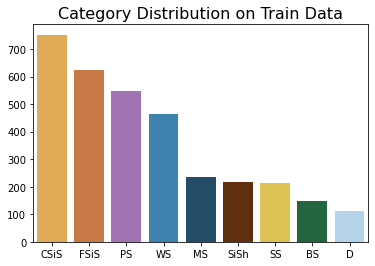

In [73]:
y_train_summary = y_train_clean.value_counts()
sns.barplot(x=y_train_summary.index,
            y=y_train_summary.values,
            palette=facies_colors_pallete,
            order=y_train_summary.index)
plt.title("Category Distribution on Train Data", fontsize=16)
plt.show()

we could see that the categories are not balance each other from the train data, for experiment purpose let's we try unbalance, undersampling, oversampling and smote sampling data to search for best model. I will use x_train, and y_train as unbalance train data

### G.2. Random Under Sampling Train Data

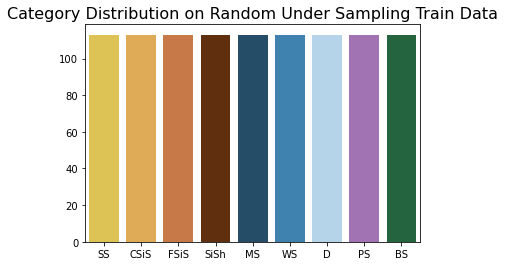

In [74]:
rus = RandomUnderSampler()
x_train_rus, y_train_rus = rus.fit_resample(X = X_train.values, y = y_train_numerical)
x_train_rus = pd.DataFrame(data=x_train_rus, columns=X_train.columns)
y_train_rus_summary = y_train_rus.value_counts()
y_train_rus_summary.index = y_train_rus_summary.index.map(inverse_facies_label_encoder)
sns.barplot(x=y_train_rus_summary.index,
            y=y_train_rus_summary.values,
            palette=facies_colors_pallete,
            order=y_train_rus_summary.index)
plt.title("Category Distribution on Random Under Sampling Train Data", fontsize=16)
plt.show()

because the smallest category is D, then the random under sampling algorithm cut the amount of others category to be the same amout as D, hence we will have least input than the unbalance training data.

### G.3. Random Over Sampling Train Data

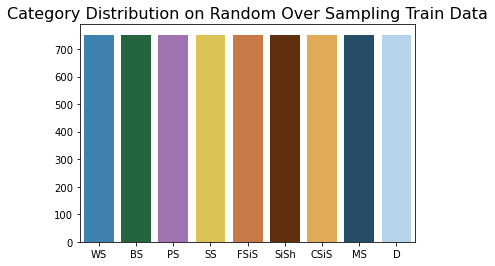

In [75]:
ros = RandomOverSampler()
x_train_ros, y_train_ros = ros.fit_resample(X = X_train.values, y=y_train_numerical)
x_train_ros = pd.DataFrame(data=x_train_ros, columns=X_train.columns)
y_train_ros_summary = y_train_ros.value_counts()
y_train_ros_summary.index = y_train_ros_summary.index.map(inverse_facies_label_encoder)
sns.barplot(x=y_train_ros_summary.index,
            y=y_train_ros_summary.values,
            palette=facies_colors_pallete,
            order=y_train_ros_summary.index)
plt.title("Category Distribution on Random Over Sampling Train Data", fontsize=16)
plt.show()

because the largest category is CSiS, then the random over sampling algorithm extend the amount of others category to be the same amout as CSiS, hence we will have more input than unblance training data

### G.4. SMOTE Sampling Train Data

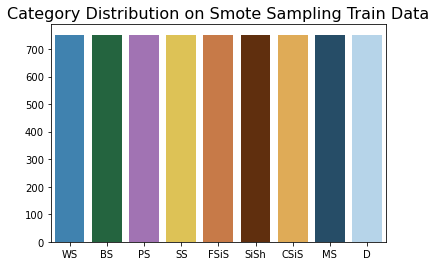

In [76]:
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(X = X_train.values,y = y_train_numerical)
x_train_smote = pd.DataFrame(data=x_train_smote, columns=X_train.columns)
y_train_smote_summary = y_train_smote.value_counts()
y_train_smote_summary.index = y_train_smote_summary.index.map(inverse_facies_label_encoder)
sns.barplot(x=y_train_smote_summary.index,
            y=y_train_smote_summary.values,
            palette=facies_colors_pallete,
            order=y_train_smote_summary.index)
plt.title("Category Distribution on Smote Sampling Train Data", fontsize=16)
plt.show()

we will get smote train data as much as over sampling training data, but with much variation in the data

In [77]:
def make_modeling_data(X_data:pd.DataFrame, y_data:pd.DataFrame) -> dict :
    rus = RandomUnderSampler()
    ros = RandomOverSampler()
    smote = SMOTE()
    
    X_train_rus, y_train_rus = rus.fit_resample(X = X_data.values, y = y_data)
    X_train_ros, y_train_ros = ros.fit_resample(X = X_data.values, y=y_data)
    X_train_smote, y_train_smote = smote.fit_resample(X = X_data.values,y = y_data)
    
    X_train_rus = pd.DataFrame(data=X_train_rus, columns=X_data.columns)
    X_train_ros = pd.DataFrame(data=X_train_ros, columns=X_data.columns)
    X_train_smote = pd.DataFrame(data=X_train_smote, columns=X_data.columns)
    
    modeling_data = {"X_train":{"unbalance":X_data, "rus":X_train_rus, "ros":X_train_ros, "smote": X_train_smote},
                     "y_train":{"unbalance":y_data, "rus":y_train_rus, "ros":y_train_ros, "smote": y_train_smote}}
    
    return modeling_data

In [78]:
train_data = make_modeling_data(X_data=X_train, y_data=y_train_numerical)

In [79]:
set(train_data['X_train'].keys())

{'ros', 'rus', 'smote', 'unbalance'}

In [80]:
util.dump_pickle(data=train_data, file_path=config['data_modeling_path'][0])

In [81]:
train_data['X_train']['unbalance']

,GR,ILD_log10,DeltaPHI,PHIND,PE,marine,non_marine
2720,-0.547132,1.102230,-0.059163,-0.881636,0.431062,0.964766,-0.964766
3372,-0.484870,0.567029,0.328611,-0.348468,-0.709061,0.964766,-0.964766
3327,1.173602,-0.352723,-0.103083,-0.001143,-0.600875,0.964766,-0.964766
2756,-0.849761,0.281589,-0.659780,-0.437561,2.095475,0.964766,-0.964766
3299,-0.832740,0.836612,-1.020339,-1.094904,0.930386,0.964766,-0.964766
...,...,...,...,...,...,...,...
3993,0.818616,-0.590590,1.367305,0.818795,-0.721831,-1.036521,1.036521
2579,-1.297748,0.023899,0.034684,-0.930359,0.549948,0.964766,-0.964766
485,-0.330627,0.959510,-0.359472,-1.146132,0.431062,0.964766,-0.964766
1214,0.176967,-1.944712,0.147300,0.433884,-0.986067,-1.036521,1.036521


In [82]:
train_data['y_train']['unbalance']

2720    5
3372    5
3327    5
2756    8
3299    7
       ..
3993    2
2579    4
485     5
1214    0
1966    2
Name: Facies, Length: 3319, dtype: int64

In [83]:
train_data['X_train']['rus']

,GR,ILD_log10,DeltaPHI,PHIND,PE,marine,non_marine
0,-0.371511,-2.615766,-0.303164,0.948955,-1.264262,-1.036521,1.036521
1,0.387820,-0.764688,0.954380,0.051060,-0.625841,-1.036521,1.036521
2,0.846530,-1.082182,0.766687,0.887007,-1.352238,-1.036521,1.036521
3,-0.099213,-0.124650,-0.209317,-0.617140,-0.579475,-1.036521,1.036521
4,-0.512273,-1.297631,-0.002855,-0.387446,-0.506954,-1.036521,1.036521
...,...,...,...,...,...,...,...
1012,-1.150825,0.745429,-1.037231,-0.280256,1.919523,0.964766,-0.964766
1013,-0.849761,0.281589,-0.659780,-0.437561,2.095475,0.964766,-0.964766
1014,-1.641228,1.197377,-2.367788,-0.763309,1.501042,0.964766,-0.964766
1015,-0.030381,-0.772955,1.273458,-0.351948,1.844679,0.964766,-0.964766


In [84]:
train_data['y_train']['rus']

0       0
1       0
2       0
3       0
4       0
       ..
1012    8
1013    8
1014    8
1015    8
1016    8
Name: Facies, Length: 1017, dtype: int64

In [85]:
train_data['X_train']['ros']

,GR,ILD_log10,DeltaPHI,PHIND,PE,marine,non_marine
0,-0.547132,1.102230,-0.059163,-0.881636,0.431062,0.964766,-0.964766
1,-0.484870,0.567029,0.328611,-0.348468,-0.709061,0.964766,-0.964766
2,1.173602,-0.352723,-0.103083,-0.001143,-0.600875,0.964766,-0.964766
3,-0.849761,0.281589,-0.659780,-0.437561,2.095475,0.964766,-0.964766
4,-0.832740,0.836612,-1.020339,-1.094904,0.930386,0.964766,-0.964766
...,...,...,...,...,...,...,...
6763,-1.405490,0.511527,-0.074741,-0.446958,1.844679,0.964766,-0.964766
6764,-1.107183,0.630460,-1.095228,-0.481969,1.454676,0.964766,-0.964766
6765,-0.728982,0.384664,0.410633,-0.603985,1.844679,0.964766,-0.964766
6766,-1.505129,3.342144,-0.580762,-0.933352,1.844679,0.964766,-0.964766


In [86]:
train_data['y_train']['ros']

0       5
1       5
2       5
3       8
4       7
       ..
6763    8
6764    8
6765    8
6766    8
6767    8
Name: Facies, Length: 6768, dtype: int64

In [87]:
train_data['X_train']['smote']

,GR,ILD_log10,DeltaPHI,PHIND,PE,marine,non_marine
0,-0.547132,1.102230,-0.059163,-0.881636,0.431062,0.964766,-0.964766
1,-0.484870,0.567029,0.328611,-0.348468,-0.709061,0.964766,-0.964766
2,1.173602,-0.352723,-0.103083,-0.001143,-0.600875,0.964766,-0.964766
3,-0.849761,0.281589,-0.659780,-0.437561,2.095475,0.964766,-0.964766
4,-0.832740,0.836612,-1.020339,-1.094904,0.930386,0.964766,-0.964766
...,...,...,...,...,...,...,...
6763,-0.529774,-1.102472,1.194133,-0.099288,1.844679,0.964766,-0.964766
6764,-0.937302,0.401211,-0.328319,-0.753619,2.197027,0.964766,-0.964766
6765,-0.790781,-1.665089,-0.501500,0.598621,2.489647,0.964766,-0.964766
6766,-0.868908,0.918584,-0.640673,-0.103336,1.124182,0.964766,-0.964766


In [88]:
train_data['y_train']['smote']

0       5
1       5
2       5
3       8
4       7
       ..
6763    8
6764    8
6765    8
6766    8
6767    8
Name: Facies, Length: 6768, dtype: int64

this **train_data** dictionary will consist of X_train and y_train for unbalance, undersampling, oversampling, and SMOTE train data. I will try this all sampling into machine learning model

## H. Feature Engineering on Test Data

we will do what has been done on the training data into the testing data

In [89]:
X_test_numerical, X_test_categorical = split_numerical_categorical(data=X_test_clean)

In [90]:
X_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830 entries, 1226 to 1401
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Formation  830 non-null    object 
 1   Well Name  830 non-null    object 
 2   Depth      830 non-null    float64
 3   GR         830 non-null    float64
 4   ILD_log10  830 non-null    float64
 5   DeltaPHI   830 non-null    float64
 6   PHIND      830 non-null    float64
 7   PE         830 non-null    float64
 8   NM_M       830 non-null    int32  
 9   RELPOS     830 non-null    float64
dtypes: float64(7), int32(1), object(2)
memory usage: 68.1+ KB


In [91]:
X_test_numerical.head(5)

,GR,ILD_log10,DeltaPHI,PHIND,PE
1226,66.187,0.510411,-12.800,28.000,2.788000
2561,66.400,0.606000,4.500,10.650,3.100000
1643,61.994,0.797000,6.988,9.147,3.204093
1122,97.407,0.609167,-6.800,24.700,3.058000
4077,52.620,0.913000,4.700,8.500,4.234412


In [92]:
X_test_categorical.head(5)

1226    2
2561    1
1643    1
1122    1
4077    2
Name: NM_M, dtype: int32

In [93]:
def categorical_handling_test_data(data:pd.Series, ohe:OneHotEncoder) -> pd.DataFrame:
    non_marine_marine_label = {1:"non_marine",2:"marine"}
    data_marine = data.map(non_marine_marine_label)
    ohe_data = ohe.transform(np.array(data_marine.to_list()).reshape(-1,1))
    ohe_data = pd.DataFrame(data=ohe_data, columns=list(ohe_train.categories_[0]), index=data_marine.index)
    
    return ohe_data

In [94]:
X_test_categorical = categorical_handling_test_data(data=X_test_categorical, ohe=ohe_train)

In [95]:
X_test_categorical.head(5)

,marine,non_marine
1226,1.0,0.0
2561,0.0,1.0
1643,0.0,1.0
1122,0.0,1.0
4077,1.0,0.0


In [96]:
def normalize_test_data(numerical_data:pd.DataFrame, categorical_data:pd.DataFrame, scaler:StandardScaler) -> pd.DataFrame:
    data = pd.concat([numerical_data, categorical_data], axis=1)
    normalized_data = scaler.transform(data.values)
    normalized_data = pd.DataFrame(data=normalized_data, index=data.index, columns=data.columns)
    
    return normalized_data

In [97]:
X_test = normalize_test_data(numerical_data=X_test_numerical,
                            categorical_data=X_test_categorical,
                            scaler=standard_scaler_train)

In [110]:
X_train.std().sum()

7.001054772853159

In [99]:
X_test.head(5)

,GR,ILD_log10,DeltaPHI,PHIND,PE,marine,non_marine
1226,0.050196,-0.600855,-3.231176,2.062623,-1.128731,0.964766,-0.964766
2561,0.057447,-0.221897,0.015915,-0.352644,-0.757805,-1.036521,1.036521
1643,-0.092540,0.535313,0.482895,-0.561874,-0.634052,-1.036521,1.036521
1122,1.112974,-0.209340,-2.105017,1.603235,-0.807737,-1.036521,1.036521
4077,-0.411646,0.995190,0.053453,-0.651942,0.590860,0.964766,-0.964766


In [100]:
X_test.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,marine,non_marine
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,0.037697,-0.047678,-0.011939,0.012426,0.015956,0.005113,-0.005113
std,1.148706,1.008222,0.949220,0.964157,0.992184,1.000406,1.000406
min,-1.751863,-2.671927,-4.263488,-1.590903,-3.254425,-1.036521,-0.964766
25%,-0.676064,-0.685737,-0.522624,-0.640632,-0.721831,-1.036521,-0.964766
50%,0.002980,-0.142608,-0.057192,-0.146268,-0.153266,0.964766,-0.964766
75%,0.484830,0.605682,0.522686,0.421738,0.668835,0.964766,1.036521
max,10.009159,4.361008,2.796025,5.948627,5.179395,0.964766,1.036521


In [101]:
y_test_numerical = facies_encoder(y_test_clean)

In [102]:
y_test_numerical.head(5)

1226    4
2561    1
1643    1
1122    1
4077    5
Name: Facies, dtype: int64

In [103]:
def create_test_data (X_data:pd.DataFrame, y_data:pd.DataFrame) -> dict:
    test_data = {'X_test':X_data, 'y_test':y_data}
    return test_data

In [104]:
test_data = create_test_data(X_data=X_test, y_data=y_test_numerical)

In [105]:
util.dump_pickle(data=test_data, file_path=config['data_modeling_path'][1])

In [106]:
test_data

{'X_test':             GR  ILD_log10  DeltaPHI     PHIND        PE    marine  non_marine
 1226  0.050196  -0.600855 -3.231176  2.062623 -1.128731  0.964766   -0.964766
 2561  0.057447  -0.221897  0.015915 -0.352644 -0.757805 -1.036521    1.036521
 1643 -0.092540   0.535313  0.482895 -0.561874 -0.634052 -1.036521    1.036521
 1122  1.112974  -0.209340 -2.105017  1.603235 -0.807737 -1.036521    1.036521
 4077 -0.411646   0.995190  0.053453 -0.651942  0.590860  0.964766   -0.964766
 ...        ...        ...       ...       ...       ...       ...         ...
 4099  0.228676   0.412416  0.147300 -0.076315  0.081348  0.964766   -0.964766
 3422 -1.076342   1.431279 -0.302413 -0.689389  0.743734  0.964766   -0.964766
 3204  0.218463  -0.154501 -2.743174  1.564953 -0.995578 -1.036521    1.036521
 382  -1.031679   1.098265 -0.939631 -1.113975  0.437006  0.964766   -0.964766
 1401  0.008495  -0.285328  0.359018 -0.263133 -0.721831 -1.036521    1.036521
 
 [830 rows x 7 columns],
 'y_test': 1226

here test data consist of X_test and y_test that has been engineered as train data, then we will use this train data and test data dictionary for modeling purpose

In [62]:
test_data['X_test']

,GR,ILD_log10,DeltaPHI,PHIND,PE,marine,non_marine
1226,0.050196,-0.600855,-3.231176,2.062623,-1.128731,0.964766,-0.964766
2561,0.057447,-0.221897,0.015915,-0.352644,-0.757805,-1.036521,1.036521
1643,-0.092540,0.535313,0.482895,-0.561874,-0.634052,-1.036521,1.036521
1122,1.112974,-0.209340,-2.105017,1.603235,-0.807737,-1.036521,1.036521
4077,-0.411646,0.995190,0.053453,-0.651942,0.590860,0.964766,-0.964766
...,...,...,...,...,...,...,...
4099,0.228676,0.412416,0.147300,-0.076315,0.081348,0.964766,-0.964766
3422,-1.076342,1.431279,-0.302413,-0.689389,0.743734,0.964766,-0.964766
3204,0.218463,-0.154501,-2.743174,1.564953,-0.995578,-1.036521,1.036521
382,-1.031679,1.098265,-0.939631,-1.113975,0.437006,0.964766,-0.964766
